# Libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf

from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# 1. Data Collection & Exploration

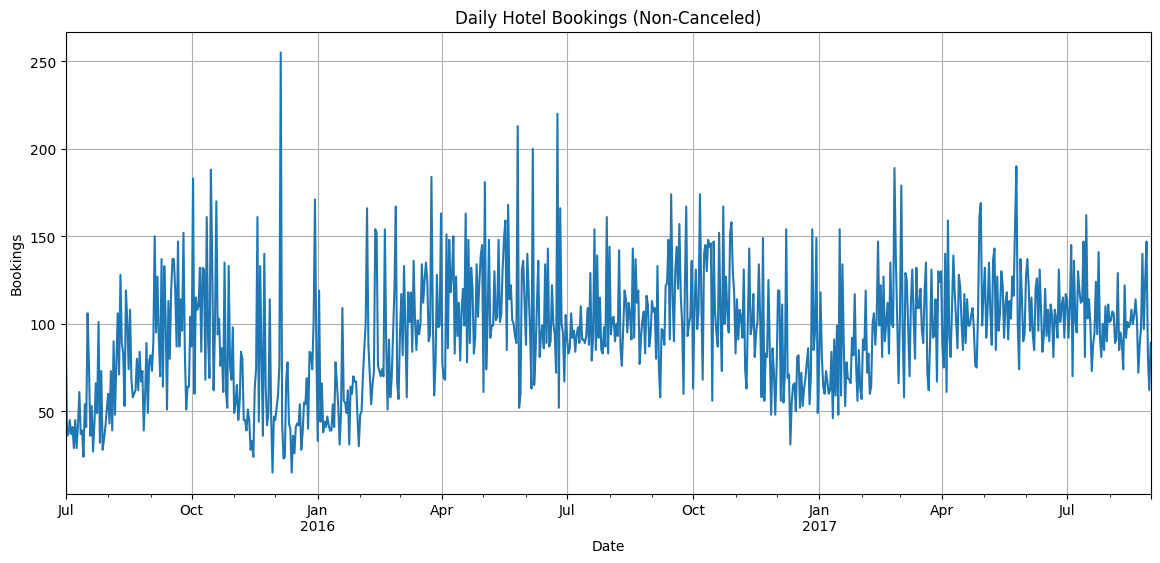

ADF Statistic: -3.6728391317227356
p-value: 0.004511827882613618
Differenced Series ADF Statistic: -10.1202989500567
p-value: 9.483895464007211e-18


In [22]:
# Load dataset
df = pd.read_csv(r'C:\Users\EVANS YORKE\Documents\Humber Courses\Fourth_Semester\Machine Learning 2-BIA -5402-0GB\Assignment\Final Group Work\hotel_bookings.csv')

# Safely fill missing values
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Unknown')
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Combine year, month, day into a datetime
df['arrival_date'] = pd.to_datetime(
    df['arrival_date_year'].astype(str) + '-' +
    df['arrival_date_month'].apply(lambda x: str(list(calendar.month_name).index(x))) + '-' +
    df['arrival_date_day_of_month'].astype(str)
)

# Set datetime index
df.set_index('arrival_date', inplace=True)

# Compute daily bookings (1 = not canceled, 0 = canceled)
df['total_bookings'] = (df['is_canceled'] == 0).astype(int)

# Resample to daily frequency
daily_bookings = df.resample('D').sum()['total_bookings']

# Plot daily bookings
plt.figure(figsize=(14, 6))
daily_bookings.plot(title='Daily Hotel Bookings (Non-Canceled)')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.grid(True)
plt.show()

# ADF test
result = adfuller(daily_bookings.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# ADF test on differenced series
diff_series = daily_bookings.diff().dropna()
result_diff = adfuller(diff_series)
print("Differenced Series ADF Statistic:", result_diff[0])
print("p-value:", result_diff[1])

# 2. Time Series Decomposition

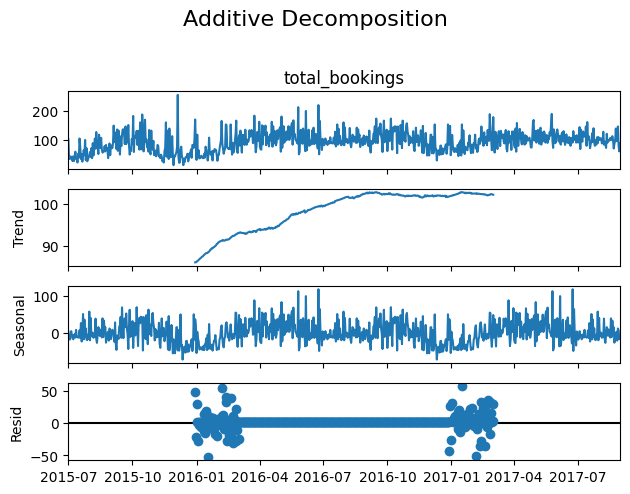

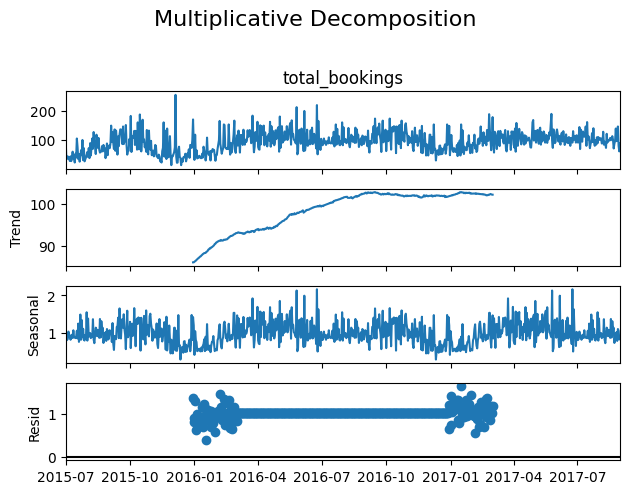

In [25]:
# --- Additive Decomposition ---
add_decomp = seasonal_decompose(daily_bookings, model='additive', period=365)
fig_add = add_decomp.plot()
fig_add.suptitle('Additive Decomposition', fontsize=16, y=1.02)  # move title slightly above
plt.tight_layout()
plt.show()

# --- Multiplicative Decomposition ---
mult_decomp = seasonal_decompose(daily_bookings.replace(0, 1), model='multiplicative', period=365)
fig_mult = mult_decomp.plot()
fig_mult.suptitle('Multiplicative Decomposition', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 3. Forecasting Models - Updated

In [28]:
# --- Train-test split ---
train = daily_bookings.iloc[:-90]
test = daily_bookings.iloc[-90:]

# --- ARIMA ---
arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()
arima_forecast = arima_result.forecast(steps=90)

# --- Exponential Smoothing (ETS) with fallback seasonal_periods ---
seasonal_periods = 365
if len(train) < 2 * seasonal_periods:
    seasonal_periods = 7  # fallback to weekly seasonality

ets_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_periods,
    initialization_method='estimated'  # avoid seasonal init error
).fit()
ets_forecast = ets_model.forecast(90)

# --- Prophet ---
df_prophet = daily_bookings.reset_index().rename(columns={
    'arrival_date': 'ds',
    'total_bookings': 'y'
})
prophet_model = Prophet()
prophet_model.fit(df_prophet.iloc[:-90])
future = prophet_model.make_future_dataframe(periods=90)
forecast = prophet_model.predict(future)

# --- LSTM ---
# --- Scale data ---
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(daily_bookings.values.reshape(-1, 1))

def create_sequences(series, window=30):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series[i-window:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_series)
X_train, X_test = X[:-90], X[-90:]
y_train, y_test = y[:-90], y[-90:]

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# --- LSTM Model ---
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=10, verbose=1)

# --- Forecast with retracing-safe function ---
@tf.function(reduce_retracing=True)
def predict_lstm(model, X):
    return model(X, training=False)

lstm_forecast = predict_lstm(lstm_model, X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast.numpy())

C:\Users\EVANS YORKE\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\EVANS YORKE\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
13:24:19 - cmdstanpy - INFO - Chain [1] start processing
13:24:19 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0564
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0184 
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194 
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0154 
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0168 
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0164 
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 


# 4. Evaluation

In [31]:
def evaluate(y_true, y_pred, name='Model'):
    print(f"\n{name} Evaluation")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    print("MSE:", mean_squared_error(y_true, y_pred))

evaluate(test, arima_forecast, "ARIMA")
evaluate(test, ets_forecast, "ETS")
evaluate(test, forecast['yhat'].iloc[-90:].values, "Prophet")
evaluate(test, lstm_forecast.flatten(), "LSTM")



ARIMA Evaluation
RMSE: 22.450205799337937
MAE: 19.02278560020206
MAPE: 20.224093259791466
MSE: 504.0117404326267

ETS Evaluation
RMSE: 25.733752646955978
MAE: 21.94267357610088
MAPE: 23.364905471494936
MSE: 662.2260252947138

Prophet Evaluation
RMSE: 19.199170365119567
MAE: 14.929498482197793
MAPE: 14.73468772865065
MSE: 368.60814270888545

LSTM Evaluation
RMSE: 19.179050237631113
MAE: 14.89818286895752
MAPE: 14.661720549474463
MSE: 367.8359680175781
